# CSCI-UA 0473 - Introduction to Machine Learning
## Wednesday, March 1, 2017

In [1]:
import sys
import numpy as np
from pprint import pprint as pp
import random
import pandas as pd

from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

np.random.seed(12345)

## 1. Data

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='/Users/jason/Downloads/') # Give an appropriate custom path

K = 10
D = 784

In [3]:
print (len(mnist['target']))
print (len(mnist['data']))

70000
70000


In [4]:
all_data = mnist['data']
all_labels = np.array([int(d) for d in mnist['target']])

In [5]:
# Class distribution
pd.DataFrame({'count': np.bincount(all_labels), 'digit': range(10)}, columns=['digit', 'count'])

,digit,count
0,0,6903
1,1,7877
2,2,6990
3,3,7141
4,4,6824
5,5,6313
6,6,6876
7,7,7293
8,8,6825
9,9,6958


In [6]:
def x_tilde(x):
    (batch_size, D) = x.shape
    data_tilde = np.concatenate([x, np.ones( (batch_size,1) )], axis=1)
    assert data_tilde.shape[1] == D+1
    return data_tilde

# Sampling data
num_train, num_valid, num_test = 1000, 100, 100
num_total = num_train + num_valid + num_test

sample_idx = np.random.choice(all_data.shape[0], num_total)
(train_idx, valid_idx, test_idx) = (sample_idx[:num_train], 
                                    sample_idx[num_train:num_train+num_valid],
                                    sample_idx[-num_test:])
print ("{} train | {} valid | {} test".format(len(train_idx), len(valid_idx), len(test_idx)))

train_data, train_labels = all_data[train_idx], all_labels[train_idx]
valid_data, valid_labels = all_data[valid_idx], all_labels[valid_idx]
test_data, test_labels = all_data[test_idx], all_labels[test_idx]

(train_data_tilde, valid_data_tilde, test_data_tilde) = (x_tilde(train_data),
                                                         x_tilde(valid_data),
                                                         x_tilde(test_data))

1000 train | 100 valid | 100 test


4
7
1
8
5


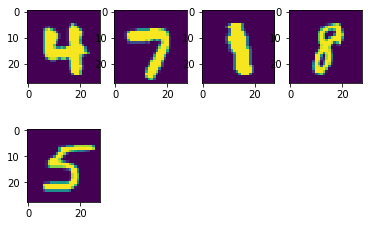

In [7]:
# Let's see how the digits look

j = 1
for i in random.sample(range(0, len(train_data)), 5):
    plt.subplot(2, 4, j)
    plt.imshow(train_data[i].reshape((28, 28)))
    print (train_labels[i])
    j += 1


In [8]:
print (train_data_tilde.shape, train_labels.shape)

(1000, 785) (1000,)


In [9]:
print (np.bincount(train_labels))

[ 88  95 124 118  99  82  93 103  97 101]


## 2. Model definition

In [10]:
def get_logits(w, data):
    # data : (batch_size, D)
    # w : (K, D)
    (K,D) = w.shape
    logits = np.matmul(data, np.transpose(w)) / D # (batch_size, K)
    return logits

def softmax(logits):
    # logits : (batch_size, K)
    logits_exp = np.exp(logits)
    all_probs = logits_exp / (np.sum(logits_exp, 1)[:,None]) # (batch_size, K)
    return all_probs

In [11]:
def eval_model(logits, labels):
    (batch_size, K) = logits.shape
    y_pred = np.argmax(logits, 1)
    right = np.sum(y_pred == labels)
    acc = right / batch_size
    return acc
    #print ("Accuracy : {:.2f}".format( right / batch_size ))

def eval_on_dataset(w, data, labels):
    (num_points, _) = data.shape
    logits = get_logits(w, data)
    all_probs = softmax(logits)
    prob = all_probs[np.arange(num_points), labels]

    cost = np.mean(distance(prob))
    acc = eval_model(logits, labels)
    return cost, acc

In [12]:
def distance(prob): # Negative Log Likelihood
    log_prob = np.log(prob + 1e-9)
    return -log_prob

In [13]:
def one_hot(batch_size, k, labels):
    output = np.zeros((batch_size, k))
    output[np.arange(batch_size), labels] = 1
    return output

def gradient(all_probs, data, labels):
    (batch_size, K) = all_probs.shape
    y_star = one_hot(batch_size, K, labels)
    grad = -1 * np.matmul( np.transpose(y_star - all_probs), data)
    # y_star - all_probs : (batch_size, K)
    # data : (batch_size, D+1)
    # grad : (K, D+1)
    return grad / batch_size

In [14]:
w0 = np.random.normal(loc=0.0, scale=1.0, size=(K, D+1))
w = np.copy(w0)
print ("weight:", w.shape)

weight: (10, 785)


In [15]:
n_epochs = 500
batch_size = 100
lr0 = 0.1
lrf = 0.001
anneal_over = 30
patience = 5
improvement = 0.999

best_w, best_e = None, None
old_cost = np.Inf
for e_idx in range(n_epochs):
    
    for b_idx in range(int(num_train/batch_size)):
        lr = max(lrf, lr0 + (lrf - lr0) * (e_idx / anneal_over) )
        #lr = lr0
        
        tr_data = train_data_tilde[b_idx * batch_size : (b_idx+1) * batch_size]
        tr_label = train_labels[b_idx * batch_size : (b_idx+1) * batch_size]

        logits = get_logits(w, tr_data)

        all_probs = softmax(logits)
        prob = all_probs[np.arange(batch_size), tr_label]

        cost = np.mean(distance(prob))
        grad = gradient(all_probs, tr_data, tr_label)

        w -= lr * grad
    
    val_cost, val_acc = eval_on_dataset(w, valid_data_tilde, valid_labels)
    print ('epoch {:4d} : lr {:.4f} acc {:.4f} | cost {:.5f}'.format(e_idx, lr, val_acc, val_cost))
    
    if val_cost / old_cost <= improvement:
        best_w = w
        best_e = e_idx
    else:
        print ('Converged')
        break

    old_cost = val_cost        
        
w = best_w

test_cost, test_acc = eval_on_dataset(w, test_data_tilde, test_labels)
print ('test acc {:.4f} | cost {:.5f}'.format(val_acc, val_cost))

epoch    0 : lr 0.1000 acc 0.4800 | cost 7.94896
epoch    1 : lr 0.0967 acc 0.7900 | cost 2.38058
epoch    2 : lr 0.0934 acc 0.8400 | cost 1.83408
epoch    3 : lr 0.0901 acc 0.9000 | cost 1.27711
epoch    4 : lr 0.0868 acc 0.8700 | cost 1.29630
Converged
test acc 0.8700 | cost 1.29630


## 3. Feature Coefficients

In [16]:
# Shape of the coefficients learned by Logistic Regression

w.shape

(10, 785)

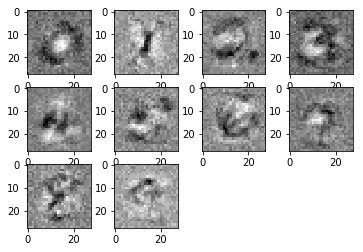

In [17]:
plt.figure()

for ii in range(w.shape[0]):
    plt.subplot(3, 4, ii+1)
    plt.imshow(w[ii,:-1].reshape(28, 28), cmap=cm.gray_r)

plt.show()